# Nov 23, 2021
## Twitch Analytics Processing And Analysis

In [1]:
%matplotlib inline
%load_ext lab_black

In [2]:
from glob import glob
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pylab as plt

sys.path.append("../src/")

from data_prep import process_stream_sessions, process_channel_analytics

In [3]:
raw_files = glob("../data/raw/*.csv")
ca_files = [f for f in raw_files if "Channel Analytics" in f]
ss_files = [f for f in raw_files if "Stream Session" in f]

print(f"{len(ca_files)} Channel Analytics Files - {len(ss_files)} Stream Session Files")

5 Channel Analytics Files - 58 Stream Session Files


## Process Stream Session Files

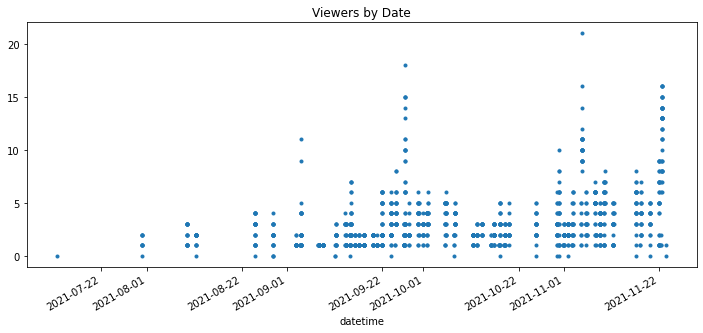

In [4]:
ss = process_stream_sessions()
ss.to_csv("../data/processed/StreamSession.csv", index=False)
ss.set_index("datetime")["Viewers"].plot(
    figsize=(12, 5), style=".", title="Viewers by Date"
)

# Process Channel Analytics

In [6]:
ca = process_channel_analytics()
ca.to_csv("../data/processed/ChannelAnalytics.csv", index=False)

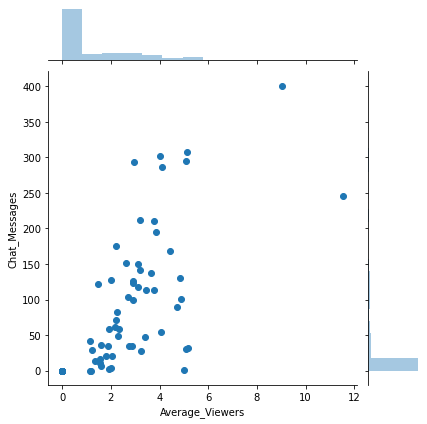

In [7]:
sns.jointplot(x="Average_Viewers", y="Chat_Messages", data=ca)

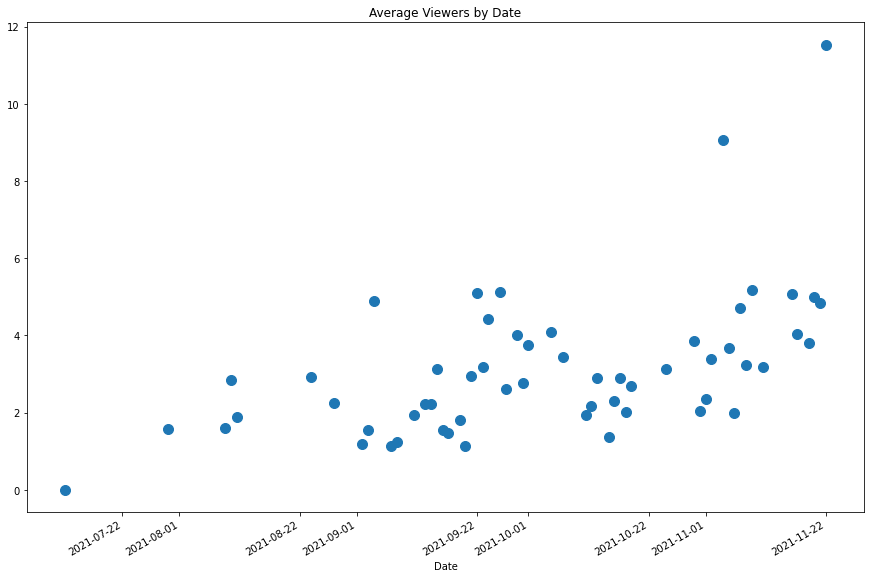

In [8]:
ca.query("streamed").set_index("Date")["Average_Viewers"].plot(
    style=".", title="Average Viewers by Date", figsize=(15, 10), ms=20
)

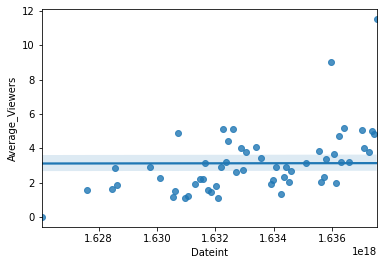

In [9]:
ca["Dateint"] = ca["Date"].view("int")
sns.regplot(data=ca.query("streamed"), x="Dateint", y="Average_Viewers")

# Review Viewers by Content

In [10]:
from pandas.api.types import CategoricalDtype

dow_order = CategoricalDtype(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ordered=True,
)

ss["hour"] = ss["datetime"].dt.hour
ss["DayOfWeek"] = ss["datetime"].dt.day_name()
ss["DayOfWeek"] = ss["DayOfWeek"].astype(dow_order)

In [11]:
ss.columns

Index(['session', 'datetime', 'Viewers', 'Live Views', 'New Followers',
       'Chatters', 'Chat Messages', 'Ad Breaks', 'Subscriptions',
       'Clips Created', 'All Clip Views', 'session_id', 'hour', 'DayOfWeek'],
      dtype='object')

In [12]:
ss["date"] = pd.to_datetime(ss["datetime"].dt.date)
ss["5mins"] = 1
ss_byday = (
    ss.groupby("date")[
        [
            "Viewers",
            "Live Views",
            "New Followers",
            "Chatters",
            "Chat Messages",
            "Ad Breaks",
            "Subscriptions",
            "Clips Created",
            "All Clip Views",
            "5mins",
        ]
    ]
    .sum()
    .reset_index()
)

ss_byday = ss_byday.rename(columns={"Viewers": "Viewers5min"})
ss_byday["AvgViewers"] = ss_byday["Viewers5min"] / ss_byday["5mins"]

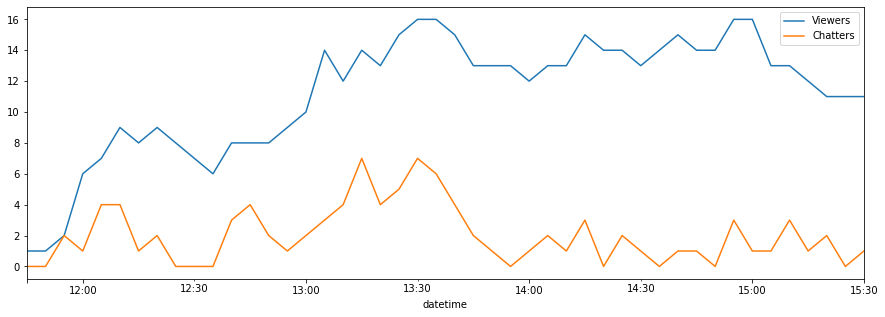

In [13]:
ss.query("date == 20211122 and hour > 5").set_index("datetime")[
    ["Viewers", "Chatters"]
].plot(figsize=(15, 5))

In [14]:
ss_byday["DayOfWeek"] = ss_byday["date"].dt.day_name().astype(dow_order)

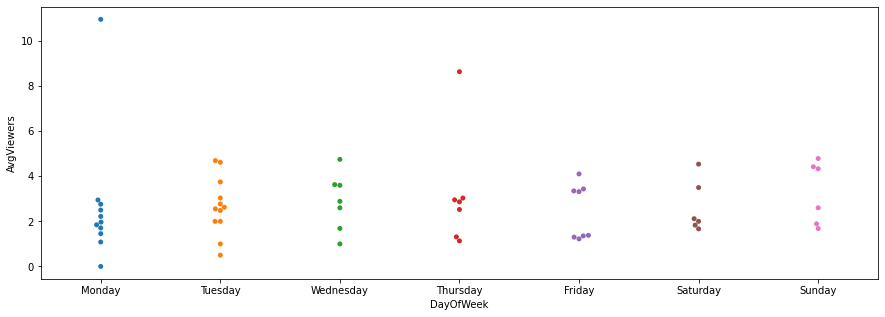

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.swarmplot(x="DayOfWeek", y="AvgViewers", data=ss_byday)

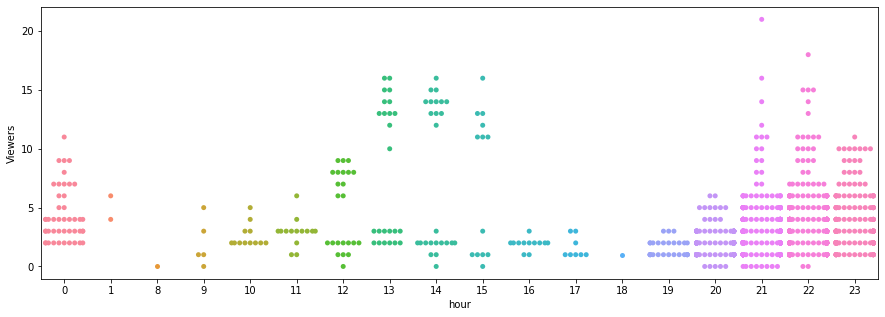

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.swarmplot(x="hour", y="Viewers", data=ss)

In [21]:
ss["start_dt"] = ss["session_id"].map(
    ss.groupby("session_id")["datetime"].min().to_dict()
)
ss["session_minute"] = (
    (ss["datetime"] - ss["start_dt"]).astype("timedelta64[m]").astype("int")
)

In [22]:
ss = ss.sort_values("datetime").reset_index(drop=True)

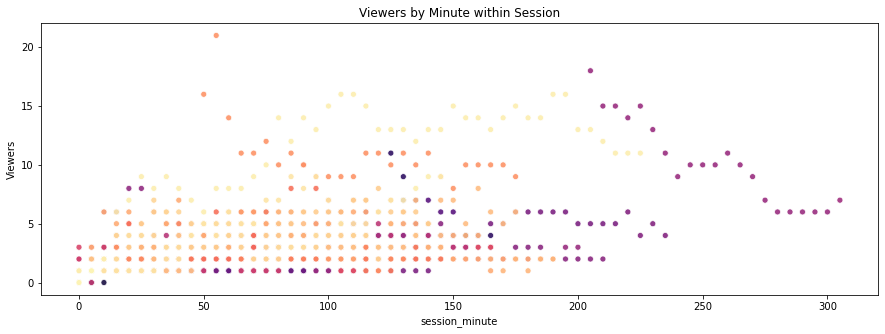

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.scatterplot(
    x="session_minute", y="Viewers", hue="date", data=ss, palette="magma", alpha=0.9
)
ax.legend().remove()
ax.set_title("Viewers by Minute within Session")
plt.show()